In [1]:
import numpy as np
import tensorflow as tf

import os
# np.random.seed(1337)  # for reproducibility
# tf.random.set_seed(1337)
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# os.environ['TF_CUDNN_DETERMINISTIC '] = '1'


# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
base_coin_str = 'DOT'
base_coin_fullname_str = 'polkadot'

alternative_coin_str = 'AAVE'
alternative_coin_fullname_str = 'Aave'

In [3]:
from data.utils import load_data
from data.scaling import normalize

filtro_tipos_eventos_permitidos = ['listing', 'launch', 'fork']
query_str = 'title.isna()'
for filtro in filtro_tipos_eventos_permitidos:
    query_str += f' or title.str.lower().str.contains("{filtro}")'
    # df = df.query(f'event_title.isna() or event_title.str.lower().str.contains("{filtro}")')
print(query_str)

title.isna() or title.str.lower().str.contains("listing") or title.str.lower().str.contains("launch") or title.str.lower().str.contains("fork")


In [4]:
df = load_data(base_coin_str, base_coin_fullname_str, event_days_left_lookback=7, storage_folder='../data', events_query=query_str)
prices, _ = normalize(df.loc[:, 'price'].to_numpy())
variation = df.loc[:, 'price (%)'].to_numpy()
# variation = df.loc[:, 'price'].pct_change().fillna(0).to_numpy()
volume, _ = normalize(df['Volume'].to_numpy())
volume_variation = df['Volume'].pct_change().fillna(0).to_numpy()
tweet, _ = normalize(df.loc[:, 'tweet_volume'].to_numpy())
tweet_variation = df.loc[:, 'tweet_volume'].pct_change().fillna(0).to_numpy()
google_trends, _ = normalize(df.loc[:, 'trend'].to_numpy())
google_trends_variation = df.loc[:, 'trend'].pct_change().fillna(0).to_numpy()

In [5]:
alternative_df = load_data(alternative_coin_str, alternative_coin_fullname_str, event_days_left_lookback=7, storage_folder='../data', events_query=query_str)

alternative_coin_prices, _ = normalize(alternative_df['price'].to_numpy())
alternative_coin_variation = alternative_df['price (%)'].to_numpy()
# variation = df.loc[:, 'price'].pct_change().fillna(0).to_numpy()
alternative_coin_volume, _ = normalize(alternative_df['Volume'].to_numpy())
alternative_coin_volume_variation = alternative_df['Volume'].pct_change().fillna(0).to_numpy()
alternative_coin_tweet, _ = normalize(alternative_df['tweet_volume'].to_numpy())
alternative_coin_tweet_variation = alternative_df['tweet_volume'].pct_change().fillna(0).to_numpy()
alternative_coin_google_trends, _ = normalize(alternative_df['trend'].to_numpy())
alternative_coin_google_trends_variation = alternative_df['trend'].pct_change().fillna(0).to_numpy()

In [6]:
from typing import Tuple
# look_behind: passos (dias) anteriores usados para prever o proximo.
N = 30
foward_days = 1  # quantos dias prever

def to_keras_format(features: list, target) -> Tuple[np.array, np.array]:
    n_samples = len(target) - N - (foward_days-1)
    # matriz de dimensao: [n_samples, N, n_features];
    features_set = np.empty((n_samples, N, len(features)))  # type: np.ndarray
    labels = [None]*n_samples
    for i in range(n_samples):
        for j in range(N):
            for ft_idx in range(len(features)):
                feature = features[ft_idx]
                features_set[i, j, ft_idx] = feature[i+j]

        labels[i] = target[N+i-1: N+i+foward_days]
    labels = np.array(labels)

    return features_set, labels

In [7]:
from keras.models import Model
from keras.layers import Input, LSTM, Dropout, Dense

def build_model(train_X, train_y) -> Model:
    inputs = Input(shape=train_X.shape[1:])
    lstm = LSTM(units=750, return_sequences=False, input_shape=train_X.shape[1:])(inputs)
    lstm = Dropout(0.1)(lstm)
    x = Dense(units=175, activation='linear')(lstm)
    x = Dropout(0.1)(x)
    x = Dense(units=75, activation='linear')(x)
    x = Dropout(0.1)(x)
    x = Dense(units=foward_days)(x)
    return Model(inputs=inputs, outputs=x)

In [8]:
from matplotlib import pyplot as plt
# vizualizando estatisticas do modelo em si e seu treino
def plot_train_history(modelo: Model, plot_above_or_below_zero_accuracy: bool, plotValidation = True, figsize=(25,10)):
    plt.rcParams['figure.figsize'] = figsize
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

    ax1.plot(modelo.history.history['loss'])
    if plotValidation: ax1.plot(modelo.history.history['val_loss'])
    ax1.title.set_text('model loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'test'], loc='upper left')

    ax2.plot(modelo.history.history['mean_squared_error'])
    if plotValidation: ax2.plot(modelo.history.history['val_mean_squared_error'])
    ax2.title.set_text('model meanSquaredError')
    ax2.set_ylabel('mse')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')

    ax3.plot(modelo.history.history['movement_accuracy'])
    if plotValidation: ax3.plot(modelo.history.history['val_movement_accuracy'])
    ax3.title.set_text('model movement direction accuracy')
    ax3.set_ylabel('accuracy')
    ax3.set_xlabel('epoch')
    ax3.legend(['train', 'test'], loc='upper left')

    # plote esse apenas se seu dado target for de variação (não faz sentido para dado bruto)
    if plot_above_or_below_zero_accuracy:
        ax4.plot(modelo.history.history['above_or_below_zero_accuracy'])
        if plotValidation: ax4.plot(modelo.history.history['val_above_or_below_zero_accuracy'])
        ax4.title.set_text('price up or down accuracy *')
        ax4.set_ylabel('accuracy')
        ax4.set_xlabel('epoch')
        ax4.legend(['train', 'test'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

In [9]:
# tf.keras.backend.clear_session() #limpa modelos e dados anteriores, para evitar vazamento de memoria
from metrics.custom import above_or_below_zero_accuracy, movement_accuracy
from metrics.custom import mean_squared_error, cosine_similarity as custom_cosine_similarity, mean_absolute_percentage_error
from metrics.custom import RootMeanSquaredError

from sklearn.model_selection import KFold, RepeatedKFold
from shutil import rmtree

def get_model_name(k, n_repeat = None):
    if n_repeat:
        return 'model_'+str(k)+'_'+str(n_repeat)+'.h5'
    return 'model_'+str(k)+'.h5'


def build_and_run_and_show(features, target, loss_function, shuffle_mask=None, epochs=400, batch_size=128) -> Model:
    save_dir = './tmp/altcoins/saved_models/'    
    if os.path.exists(save_dir):
        rmtree(save_dir)

    features_set, labels = to_keras_format(features, target)

    if shuffle_mask == None:
        shuffle_mask = np.arange(len(features_set))
        np.random.shuffle(shuffle_mask)

    unshuffle_mask = np.zeros(len(shuffle_mask), dtype=int)
    for i in range(len(shuffle_mask)):
        unshuffle_mask[shuffle_mask[i]] = i

    features_set, labels = features_set[shuffle_mask], labels[shuffle_mask]

    
    TEST_MSE, TEST_MAPE, TEST_MOV_ACCURACY, TEST_UPDOWN_ACCURACY = [], [], [], []
    # kf = KFold(n_splits = 5)
    n_repeats = 2
    kf = RepeatedKFold(n_splits = 5, n_repeats = n_repeats, random_state=1337) # random_state fixo para manter reproducibilidade entre chamadas dessa função

    fold_num = 1
    repeat_num = 1
    for train_index, test_index  in kf.split(features_set, labels):
        tf.keras.backend.clear_session()

        train_X, train_y = features_set[train_index], labels[train_index]
        test_X, test_y = features_set[test_index], labels[test_index]

        model = build_model(train_X, train_y)
        opt = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
        model.compile(optimizer=opt, loss=loss_function, metrics=[mean_squared_error, movement_accuracy, above_or_below_zero_accuracy])# 'cosine_similarity', 'mean_squared_error'

        # CREATE CALLBACKS
        best_mse_checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+'mse/'+get_model_name(fold_num, repeat_num),#+'_{epoch:03d}-{val_mean_squared_error:.5f}', 
                                monitor='val_mean_squared_error', verbose=0, save_best_only=True, mode='min')
        best_movAcc_checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+'mov_accuracy/'+get_model_name(fold_num, repeat_num),#+'_{epoch:03d}-{val_movement_accuracy:.5f}', 
                                monitor='val_movement_accuracy', verbose=0, save_best_only=True, mode='max')
        best_above_below_zero_checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+'above_or_below_zero_accuracy/'+get_model_name(fold_num, repeat_num),#+'_{epoch:03d}-{val_movement_accuracy:.5f}', 
                                monitor='val_above_or_below_zero_accuracy', verbose=0, save_best_only=True, mode='max')
        checkpoints = [best_mse_checkpoint, best_mape_checkpoint, best_movAcc_checkpoint, best_above_below_zero_checkpoint]

        print(f'treinando fold {fold_num}, repetição {repeat_num} (400 epochs dá 2min +-)')
        model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=epochs, batch_size=batch_size, callbacks=checkpoints, verbose=0)
        

        # PLOT HISTORY
        plot_train_history(model, plot_above_or_below_zero_accuracy=True, figsize=(25,8))

        # LOAD BEST MODEL (for specific metric) to evaluate the performance of the model
        model.load_weights(save_dir+"mse/"+get_model_name(fold_num, repeat_num))
        results = model.evaluate(x=test_X, y=test_y, batch_size=1)
        results = dict(zip(model.metrics_names, results))
        TEST_MSE.append(results['mean_squared_error'])
        
        model.load_weights(save_dir+"mov_accuracy/"+get_model_name(fold_num, repeat_num))
        results = model.evaluate(x=test_X, y=test_y, batch_size=1)
        results = dict(zip(model.metrics_names, results))
        TEST_MOV_ACCURACY.append(results['movement_accuracy'])

        model.load_weights(save_dir+"above_or_below_zero_accuracy/"+get_model_name(fold_num, repeat_num))
        results = model.evaluate(x=test_X, y=test_y, batch_size=1)
        results = dict(zip(model.metrics_names, results))
        TEST_UPDOWN_ACCURACY.append(results['above_or_below_zero_accuracy'])

        if repeat_num % n_repeats == 0:
            fold_num +=1
            repeat_num = 1
        else:    
            repeat_num += 1        

        rmtree(save_dir)
        tf.keras.backend.clear_session()

    print('\nResults:\n')
    print(f'MeanSquaredError: {TEST_MSE}')
    print(f'MeanAbsolutePercentageError: {TEST_MAPE}')
    print(f'MovementDiretionAccuracy: {TEST_MOV_ACCURACY}')
    print(f'AboveOrBellowAccuracy: {TEST_UPDOWN_ACCURACY}\n')
    print(f'MeanSquaredError mean: {np.mean(TEST_MSE)}')
    print(f'MeanAbsolutePercentageError mean: {np.mean(TEST_MAPE)}')
    print(f'MovementDiretionAccuracy mean: {np.mean(TEST_MOV_ACCURACY)}')
    print(f'AboveOrBellowAccuracy mean: {np.mean(TEST_UPDOWN_ACCURACY)}\n')
    print(f'MeanSquaredError std: {np.std(TEST_MSE)}')
    print(f'MeanAbsolutePercentageError std: {np.std(TEST_MAPE)}')
    print(f'MovementDiretionAccuracy std: {np.std(TEST_MOV_ACCURACY)}')
    print(f'AboveOrBellowAccuracy std: {np.std(TEST_UPDOWN_ACCURACY)}')

    return

In [10]:
import cv2
def plot_predictions_and_save(testPredict: np.array, test_y: np.array, base_coin:str, alternative_coin:str):
    predictions = testPredict
    targets_test = test_y[:, -1:].tolist()
    # prediction tem um shape (samples, foward_days), entao vamos pegar previsoes de foward_days dias, a cada partir de pontos com intervalo de foward_days
    foward_days_predictions = []
    for i in range(1, predictions.shape[0], foward_days):
        foward_days_predictions.append(np.array([None]*(i-1) + targets_test[i-1] +
                                                predictions[i].tolist() +
                                                [None]*(predictions.shape[0]-(i+foward_days))))

    fig = plot_data([targets_test] + foward_days_predictions, tick=10, legends=['target', 'prediction'],
                        colors=['b', 'r'] + ['r']*len(foward_days_predictions), blocking=False, figsize=(160,20))
    fig.savefig('1.png')
    # 1 day predictions
    fig = plot_data([targets_test, predictions[:, 0]], tick=10, legends=['target', 'prediction'], blocking=False, figsize=(160,20))
    fig.savefig('2.png')

    im_v = cv2.vconcat([cv2.imread('1.png'), cv2.imread('2.png')])
    if not os.path.exists('../resultados/generic_model/'):
        os.mkdir('../resultados/generic_model/')
    cv2.imwrite(f'../resultados/generic_model/{base_coin} trained - {alternative_coin} forecasting.png', im_v)


def plot_predictions(testPredict: np.array, test_y: np.array):
    predictions = testPredict
    targets_test = test_y[:, -1:].tolist()
    # prediction tem um shape (samples, foward_days), entao vamos pegar previsoes de foward_days dias, a cada partir de pontos com intervalo de foward_days
    foward_days_predictions = []
    for i in range(1, predictions.shape[0], foward_days):
        foward_days_predictions.append(np.array([None]*(i-1) + targets_test[i-1] +
                                                predictions[i].tolist() +
                                                [None]*(predictions.shape[0]-(i+foward_days))))

    plot_data([targets_test] + foward_days_predictions, tick=10, legends=['target', 'prediction'],
                        colors=['b', 'r'] + ['r']*len(foward_days_predictions), blocking=False, figsize=(160,20))
    # 1 day predictions
    plot_data([targets_test, predictions[:, 0]], tick=10, legends=['target', 'prediction'], blocking=False, figsize=(160,30))

# testando uma rede treinada em uma moeda, sendo usada para outra

In [14]:
from data.visualization import plot_data
save_dir = './tmp/altcoins/saved_models/'
def generate_checkPoints():
    best_mse_checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+'mse/best.h5', monitor='val_mean_squared_error', verbose=0, save_best_only=True, mode='min')
    # best_mape_checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+'mape/best.h5', monitor='val_mean_absolute_percentage_error', verbose=0, save_best_only=True, mode='min')
    best_movAcc_checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+'mov_accuracy/best.h5', monitor='val_movement_accuracy', verbose=0, save_best_only=True, mode='max')
    best_above_below_zero_checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+'above_or_below_zero_accuracy/best.h5', monitor='val_above_or_below_zero_accuracy', verbose=0, save_best_only=True, mode='max')
    checkpoints = [best_mse_checkpoint, best_movAcc_checkpoint, best_above_below_zero_checkpoint]
    return checkpoints

def train_and_test(train_data:tuple, test_data:tuple, epochs=400):
    print('Testa a perfomance treinando com moeda base e prevendo moeda alternativa')
    tf.keras.backend.clear_session()
    if os.path.exists(save_dir):
            rmtree(save_dir)

    train_X, train_y = train_data
    test_X, test_y = test_data
    

    modelo = build_model(train_X, train_y)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
    modelo.compile(optimizer=opt, loss=mean_squared_error, metrics=[mean_squared_error, movement_accuracy, above_or_below_zero_accuracy])
    modelo.fit(train_X, train_y, validation_data=(test_X, test_y),epochs=epochs, batch_size=128, callbacks=generate_checkPoints(), verbose=1)

    plot_train_history(modelo, plot_above_or_below_zero_accuracy=True, plotValidation=True, figsize=(25,8))

    # LOAD BEST MODEL (for specific metric) to evaluate the performance of the model
    modelo.load_weights(save_dir+"mse/best.h5")
    results_mse = modelo.evaluate(x=test_X, y=test_y, batch_size=1)
    testPredict = modelo.predict(test_X)    # para plotar o gráfico, vamos usar o com melhor mse

    modelo.load_weights(save_dir+"mape/best.h5")
    results_mape = modelo.evaluate(x=test_X, y=test_y, batch_size=1)

    modelo.load_weights(save_dir+"mov_accuracy/best.h5")
    results_movAcc = modelo.evaluate(x=test_X, y=test_y, batch_size=1)

    modelo.load_weights(save_dir+"above_or_below_zero_accuracy/best.h5")
    results_upDownAcc = modelo.evaluate(x=test_X, y=test_y, batch_size=1)

    print('moeda alternativa Score:', [results_mse[1], results_movAcc[2], results_upDownAcc[3]])

    plot_predictions_and_save(testPredict=testPredict, test_y=test_y, base_coin=base_coin_str, alternative_coin=alternative_coin_str)    

## Treina e testa com os dados da moeda alternativa

treinando fold 1, repetição 1 (400 epochs dá 2min +-)


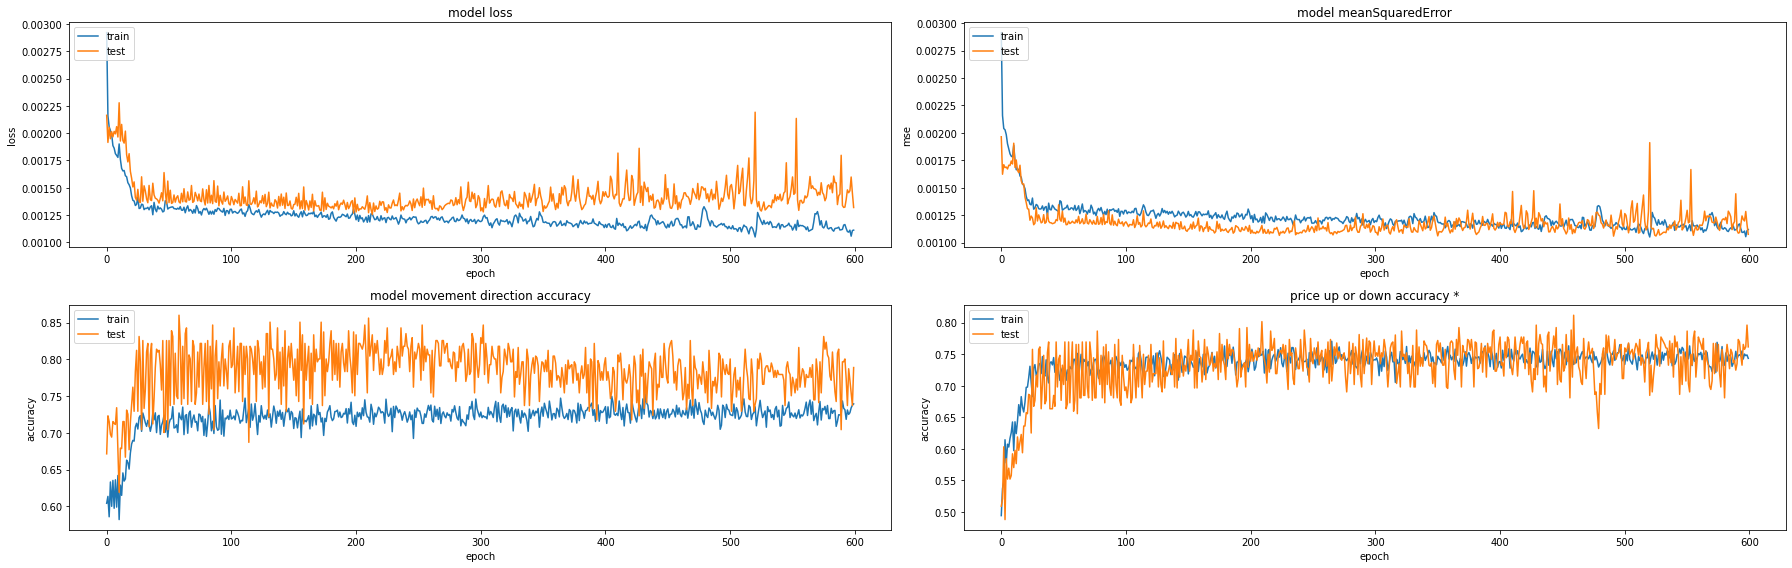

157/157 [==============================] - 1s 7ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_percentage_error: 301.2836 - movement_accuracy: 0.7834 - above_or_below_zero_accuracy: 0.7580
treinando fold 1, repetição 2 (400 epochs dá 2min +-)


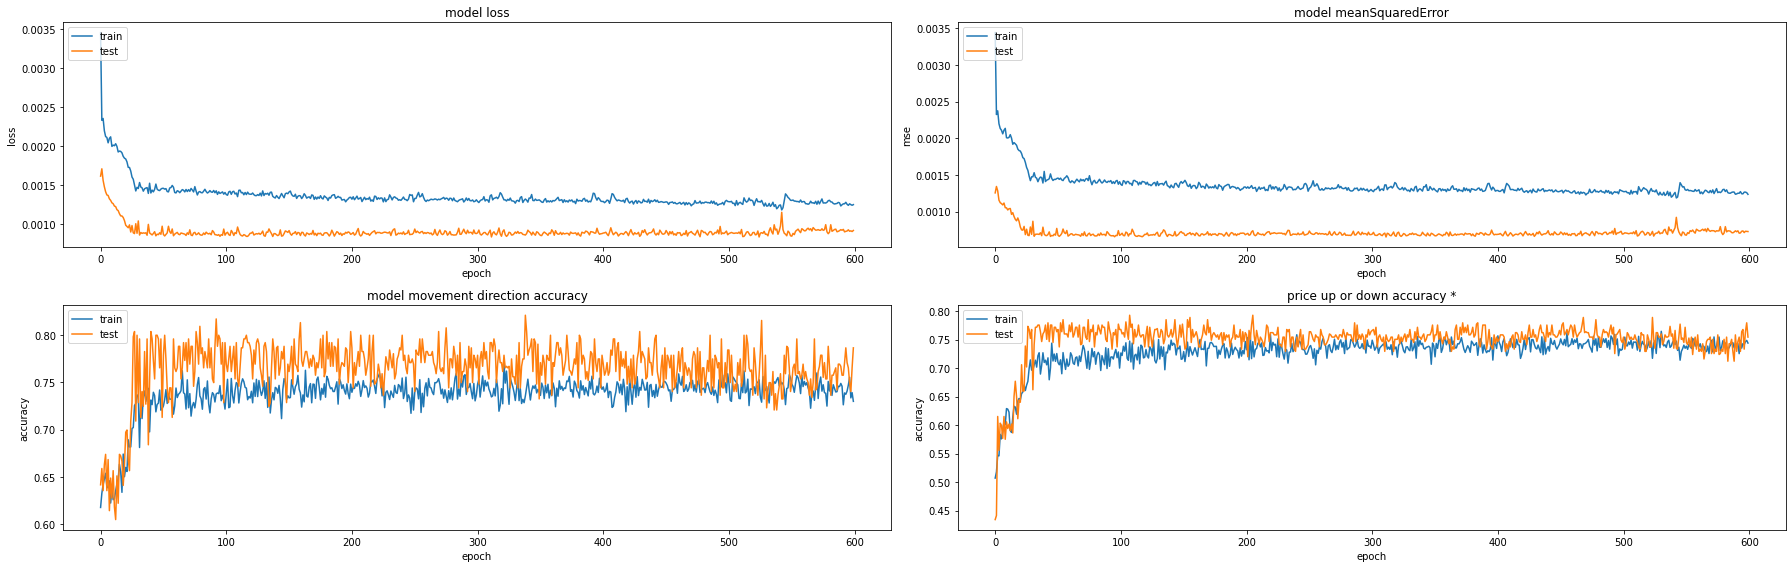

157/157 [==============================] - 1s 7ms/step - loss: 8.8657e-04 - mean_squared_error: 8.8657e-04 - mean_absolute_percentage_error: 239.5403 - movement_accuracy: 0.7070 - above_or_below_zero_accuracy: 0.7707
treinando fold 2, repetição 1 (400 epochs dá 2min +-)


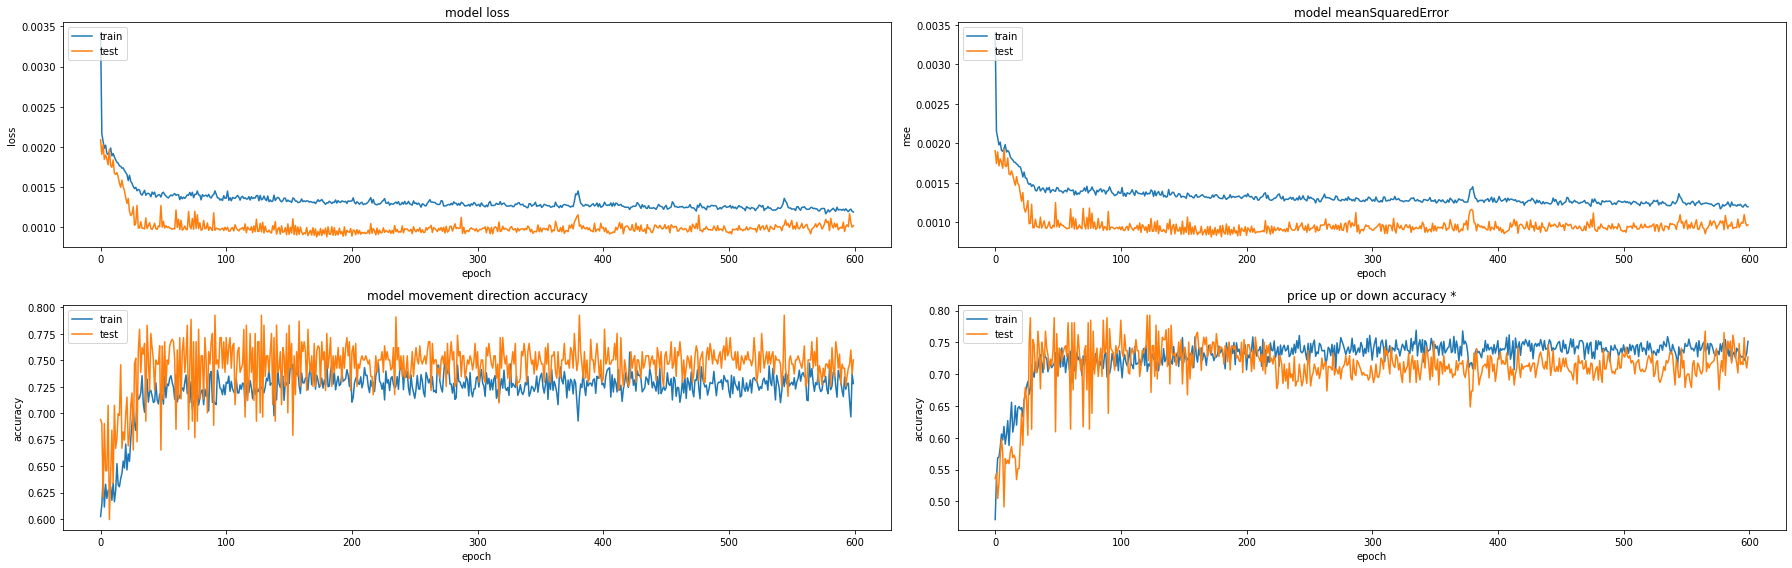

157/157 [==============================] - 1s 7ms/step - loss: 9.3608e-04 - mean_squared_error: 9.3608e-04 - mean_absolute_percentage_error: 269.1100 - movement_accuracy: 0.7643 - above_or_below_zero_accuracy: 0.7707
treinando fold 2, repetição 2 (400 epochs dá 2min +-)


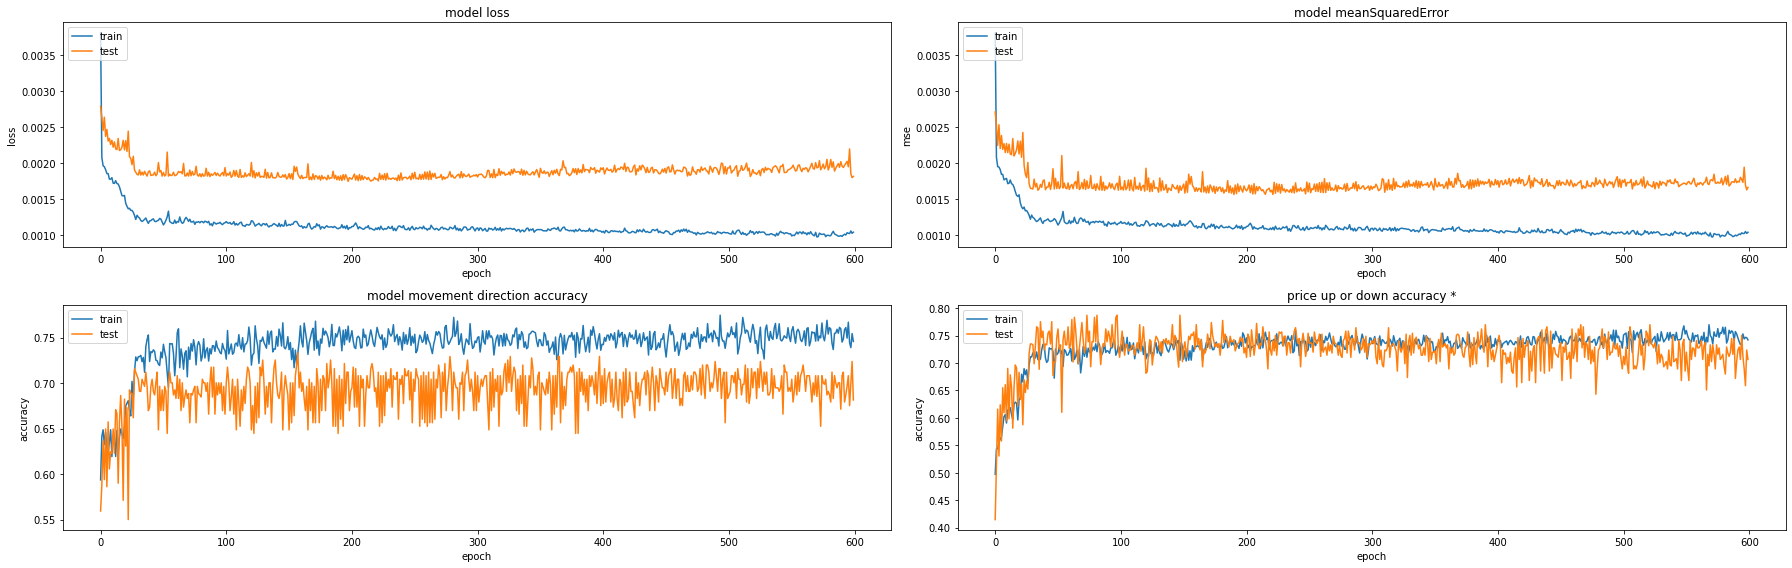

157/157 [==============================] - 1s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_percentage_error: 226.2320 - movement_accuracy: 0.7070 - above_or_below_zero_accuracy: 0.7834
treinando fold 3, repetição 1 (400 epochs dá 2min +-)


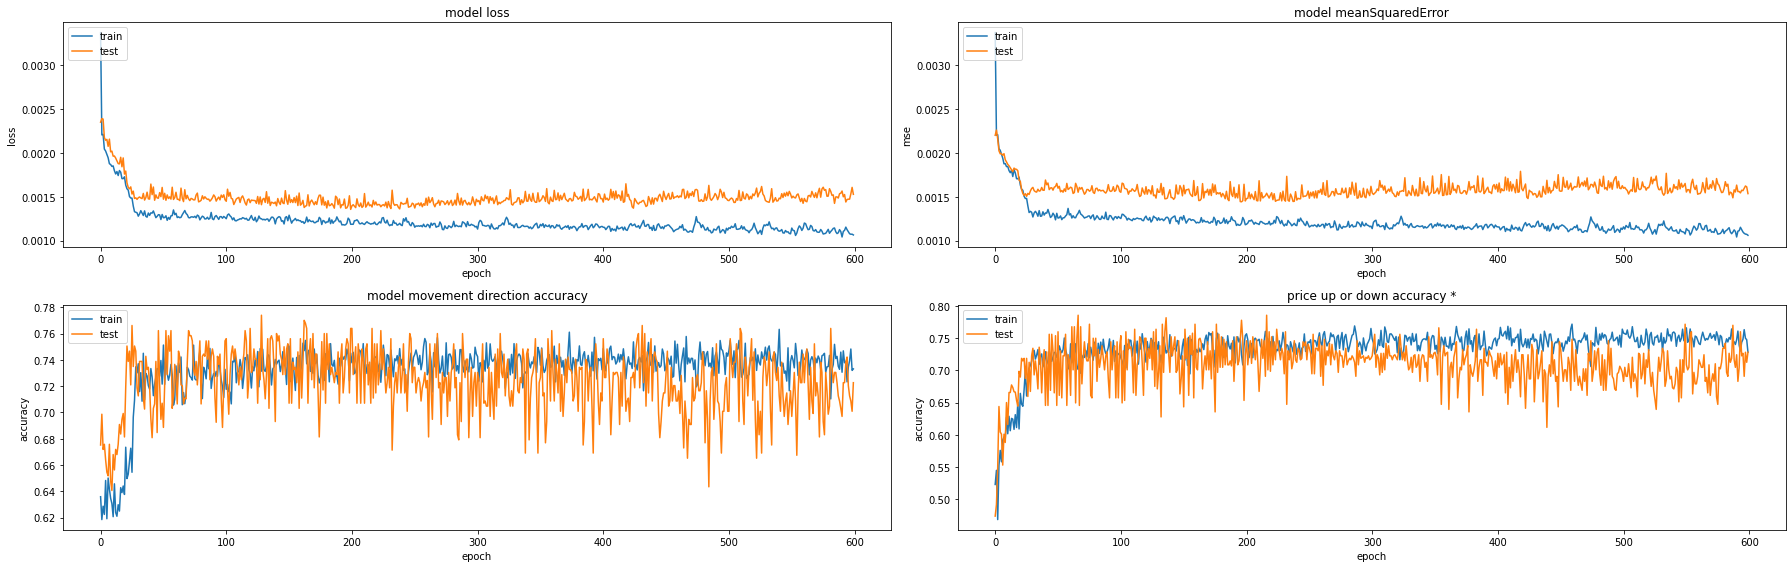

156/156 [==============================] - 1s 7ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_percentage_error: 171.2151 - movement_accuracy: 0.7244 - above_or_below_zero_accuracy: 0.7628
treinando fold 3, repetição 2 (400 epochs dá 2min +-)


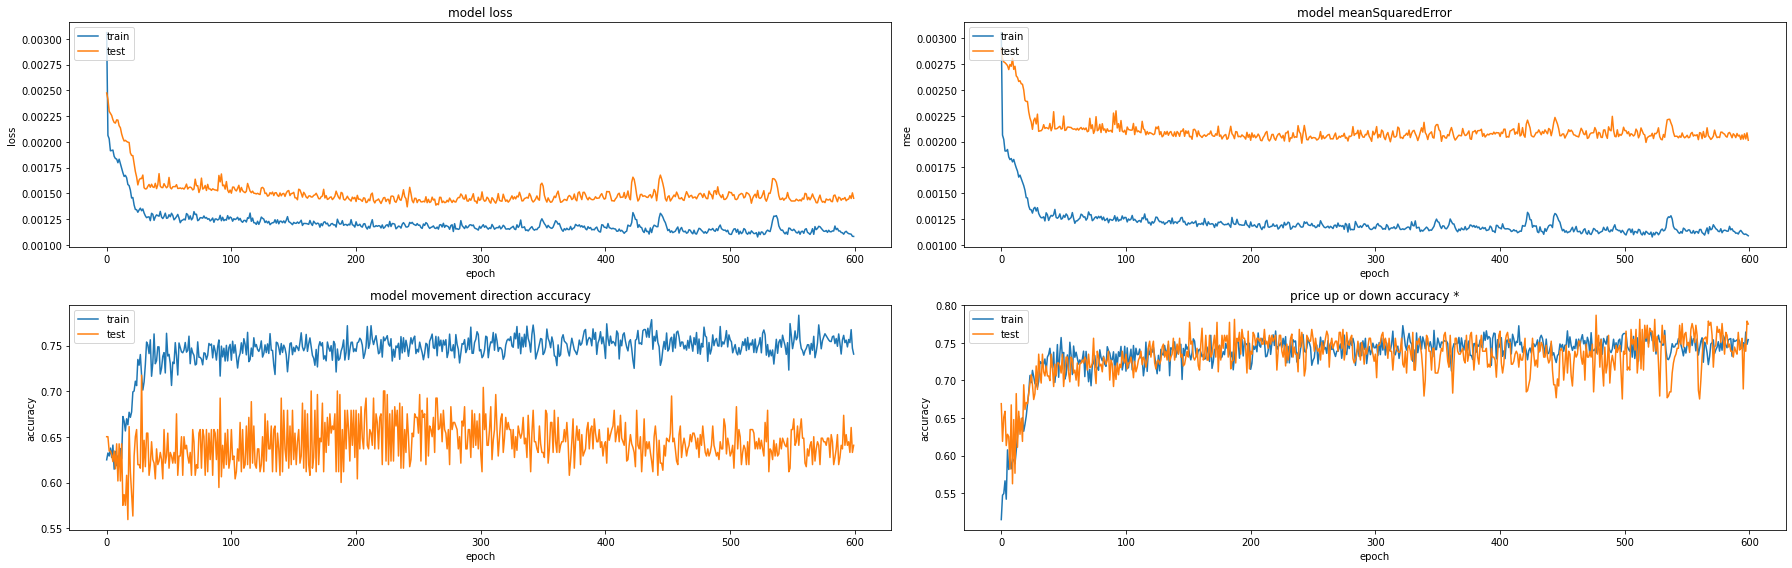

157/157 [==============================] - 1s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_percentage_error: 209.3070 - movement_accuracy: 0.6752 - above_or_below_zero_accuracy: 0.7389
treinando fold 4, repetição 1 (400 epochs dá 2min +-)


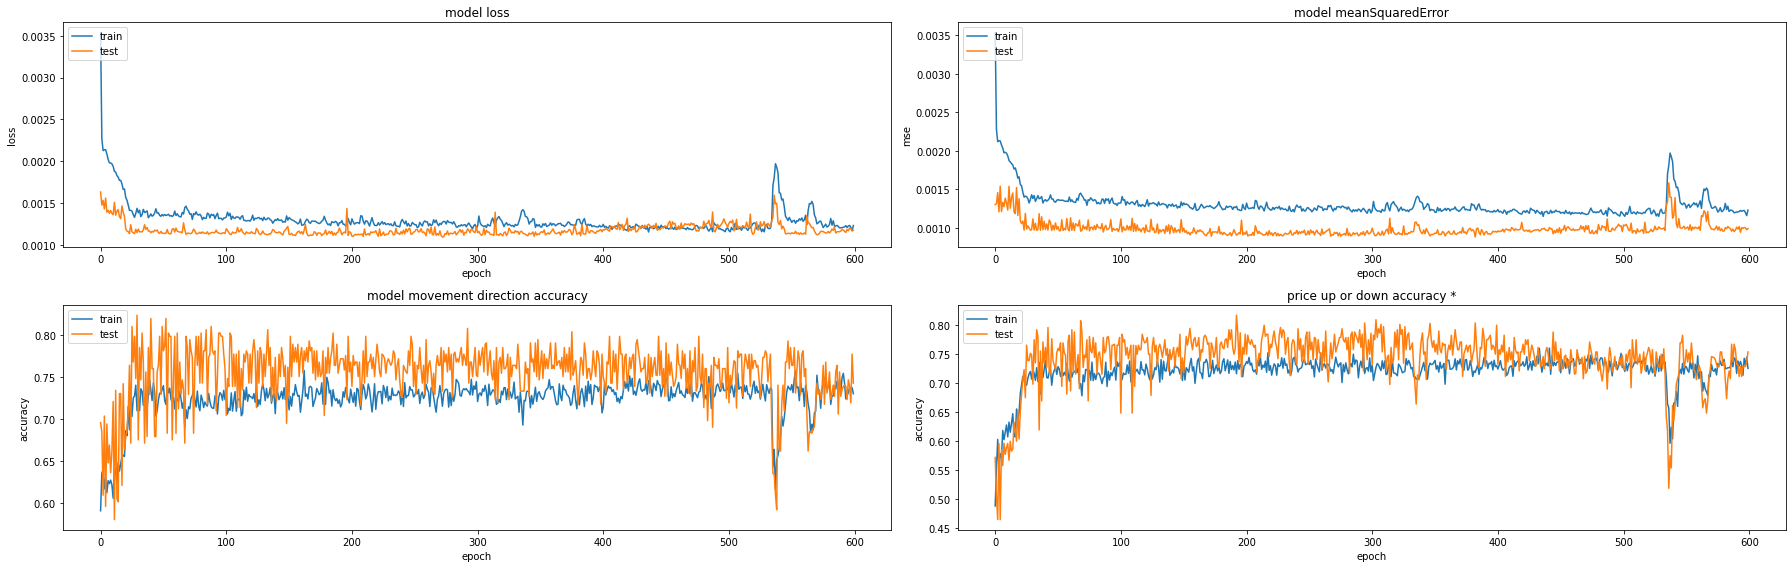

157/157 [==============================] - 1s 7ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_percentage_error: 202.5486 - movement_accuracy: 0.7580 - above_or_below_zero_accuracy: 0.7898
treinando fold 4, repetição 2 (400 epochs dá 2min +-)


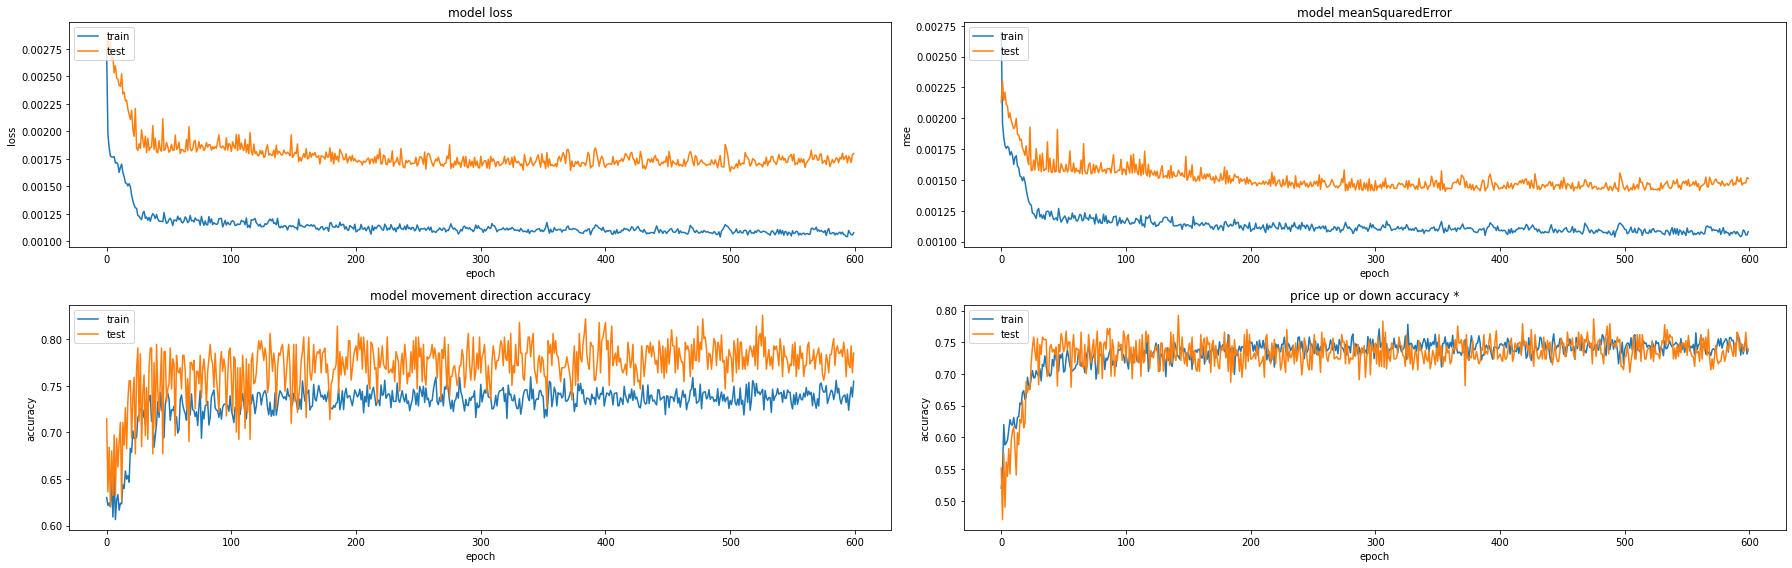

157/157 [==============================] - 1s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_percentage_error: 315.3090 - movement_accuracy: 0.7452 - above_or_below_zero_accuracy: 0.7707
treinando fold 5, repetição 1 (400 epochs dá 2min +-)


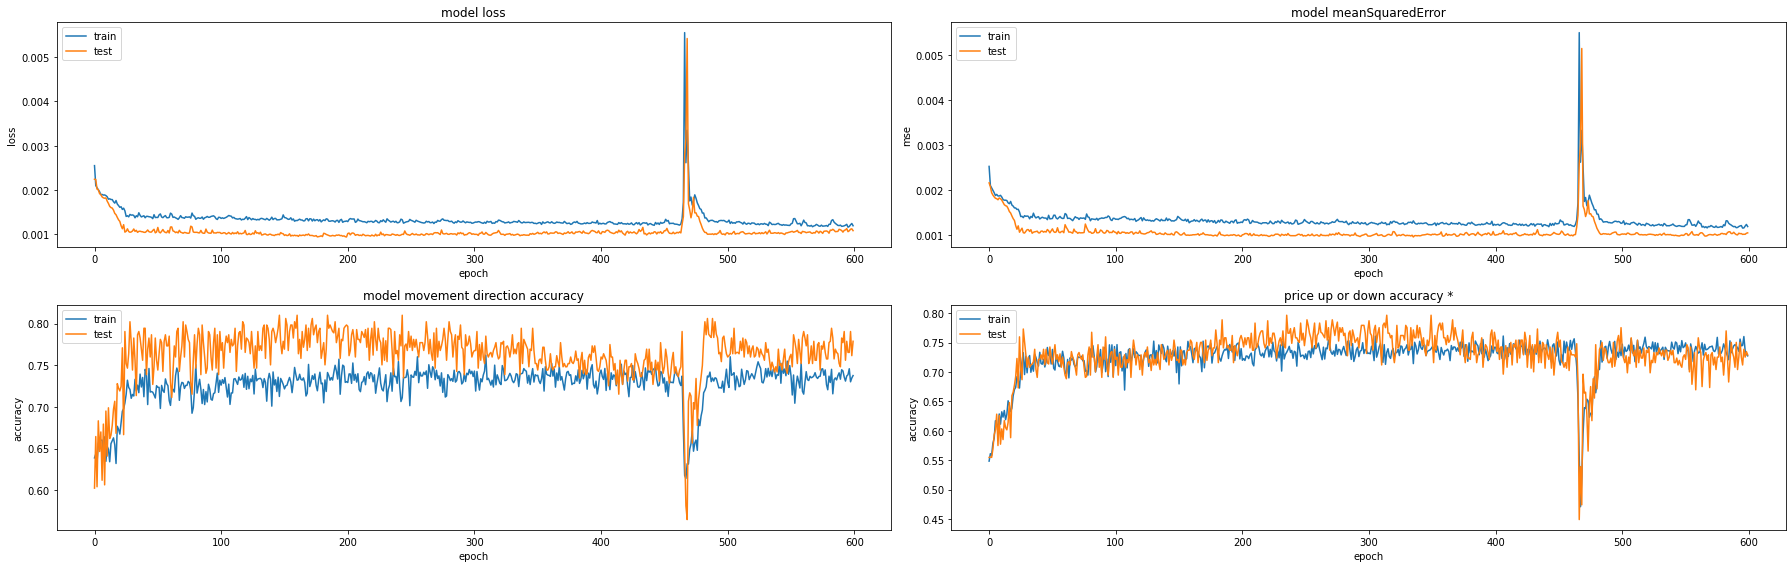

157/157 [==============================] - 1s 7ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_percentage_error: 204.1578 - movement_accuracy: 0.7516 - above_or_below_zero_accuracy: 0.7771
treinando fold 5, repetição 2 (400 epochs dá 2min +-)


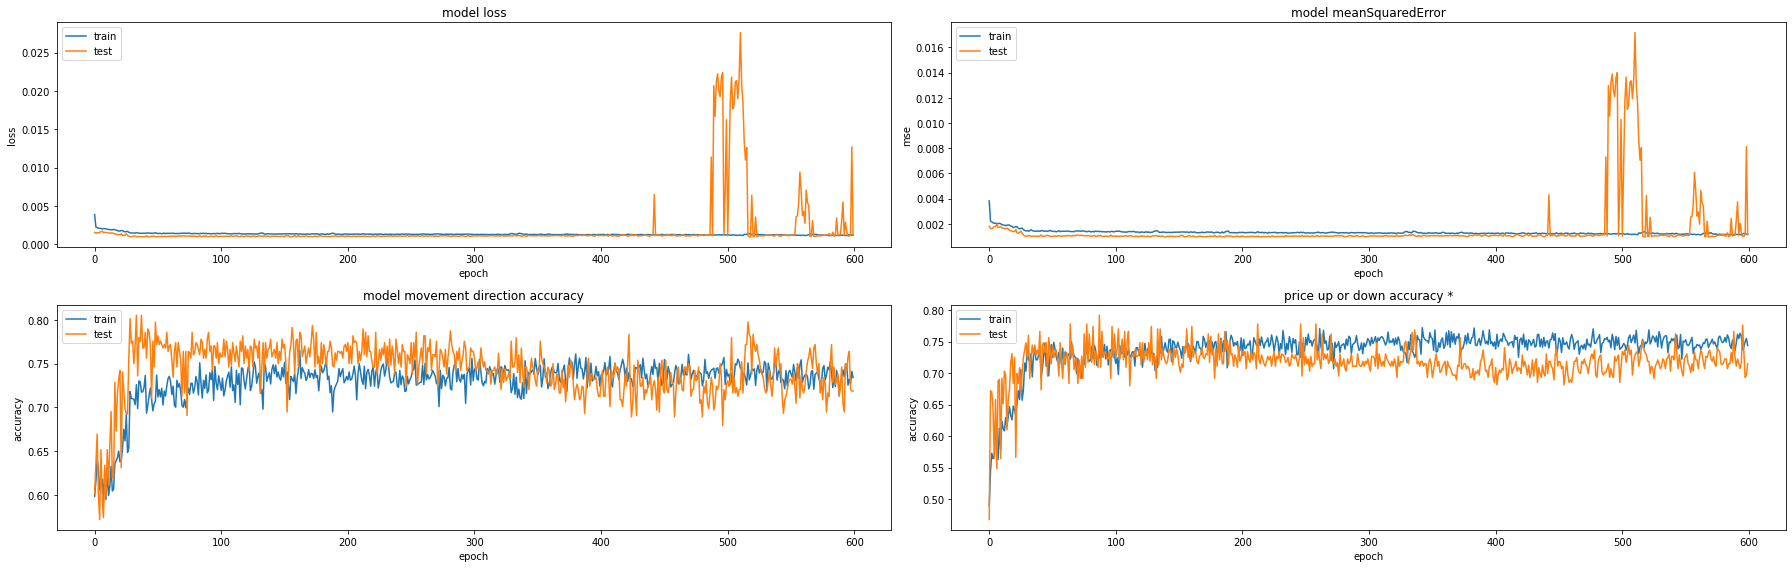

156/156 [==============================] - 1s 7ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_percentage_error: 319.9123 - movement_accuracy: 0.7308 - above_or_below_zero_accuracy: 0.7500

Results:

MeanSquaredError: [0.001302427495829761, 0.0008307339739985764, 0.0008818632340990007, 0.0017630038782954216, 0.0013738975394517183, 0.0013702106662094593, 0.0011101213749498129, 0.0016860254108905792, 0.0009906303603202105, 0.0009559926693327725]
MeanAbsolutePercentageError: [237.99415588378906, 119.77098846435547, 165.3888397216797, 174.9059600830078, 106.81160736083984, 125.3253402709961, 116.4393539428711, 185.13487243652344, 108.6061019897461, 183.4942169189453]
MovementDiretionAccuracy: [0.8152866363525391, 0.7515923380851746, 0.7707006335258484, 0.7388535141944885, 0.7435897588729858, 0.7133758068084717, 0.7770700454711914, 0.8025477528572083, 0.7770700454711914, 0.7948718070983887]
AboveOrBellowAccuracy: [0.7579618096351624, 0.7707006335258484, 0.770700633525848

In [12]:
features = [alternative_coin_variation]
target = alternative_coin_variation

model_mse = build_and_run_and_show(features, target, mean_squared_error, epochs = 600)  # nao teve overfitting até o epoch 400, entao bora forçar mais uns pra ver se tira mais ganho
print(f'Esse é o score do {alternative_coin_fullname_str} num modelo treinado por ele mesmo (mesma moeda, mas trechos de dados diferentes)\n foi usada validação cruzada (K-Fold)')

## Testa a perfomance treinando com moeda base e prevendo moeda alternativa

=====] - 0s 52ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_percentage_error: 223.5661 - movement_accuracy: 0.7206 - above_or_below_zero_accuracy: 0.7205 - val_loss: 0.0012 - val_mean_squared_error: 0.0013 - val_mean_absolute_percentage_error: 247.3486 - val_movement_accuracy: 0.7556 - val_above_or_below_zero_accuracy: 0.7310
Epoch 552/600
9/9 [==============================] - 0s 52ms/step - loss: 9.1971e-04 - mean_squared_error: 9.1979e-04 - mean_absolute_percentage_error: 191.5996 - movement_accuracy: 0.7192 - above_or_below_zero_accuracy: 0.7180 - val_loss: 0.0012 - val_mean_squared_error: 0.0013 - val_mean_absolute_percentage_error: 252.4607 - val_movement_accuracy: 0.7545 - val_above_or_below_zero_accuracy: 0.7366
Epoch 553/600
9/9 [==============================] - 0s 52ms/step - loss: 8.6353e-04 - mean_squared_error: 8.6568e-04 - mean_absolute_percentage_error: 188.3295 - movement_accuracy: 0.7572 - above_or_below_zero_accuracy: 0.7213 - val_loss: 0.0012 -

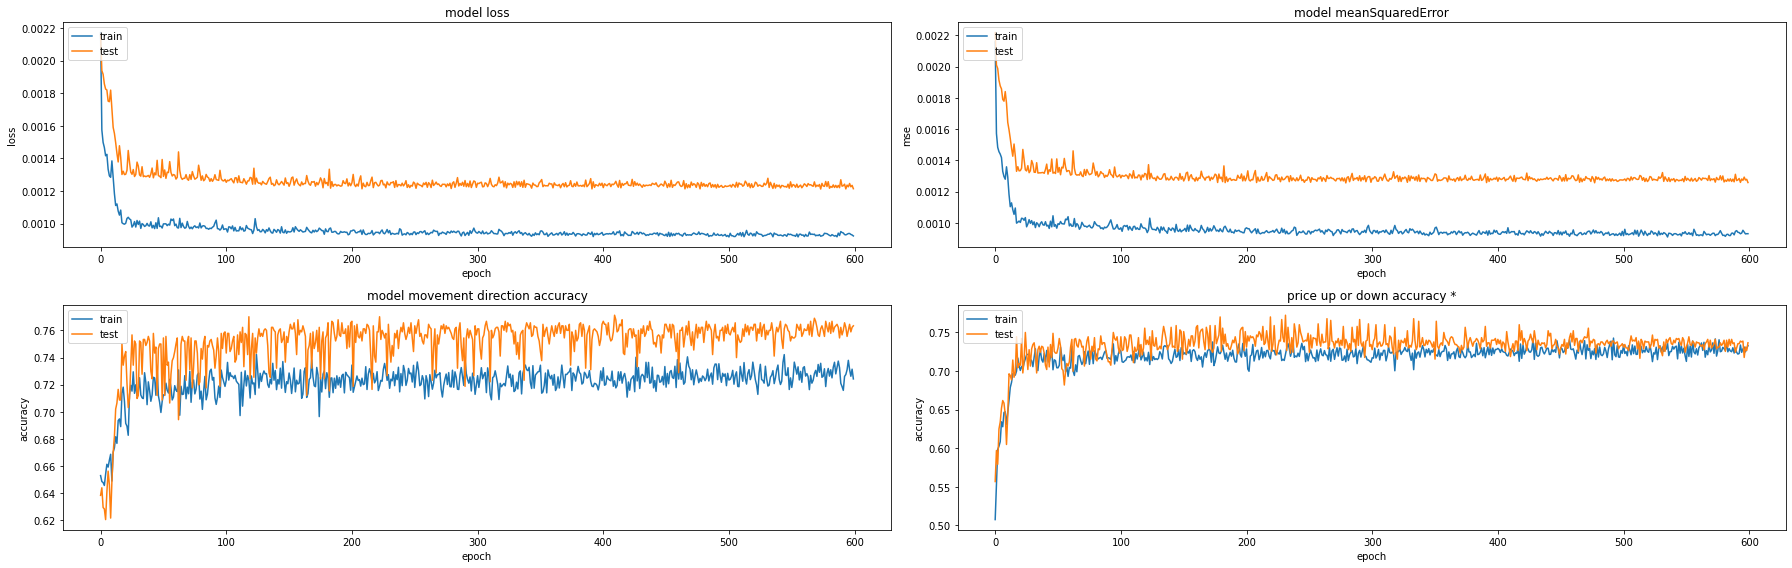

784/784 [==============================] - 6s 8ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_percentage_error: 247.8932 - movement_accuracy: 0.7436 - above_or_below_zero_accuracy: 0.7577
moeda alternativa Score: [0.0012151057599112391, 182.9781494140625, 0.7653061151504517, 0.7576530575752258]


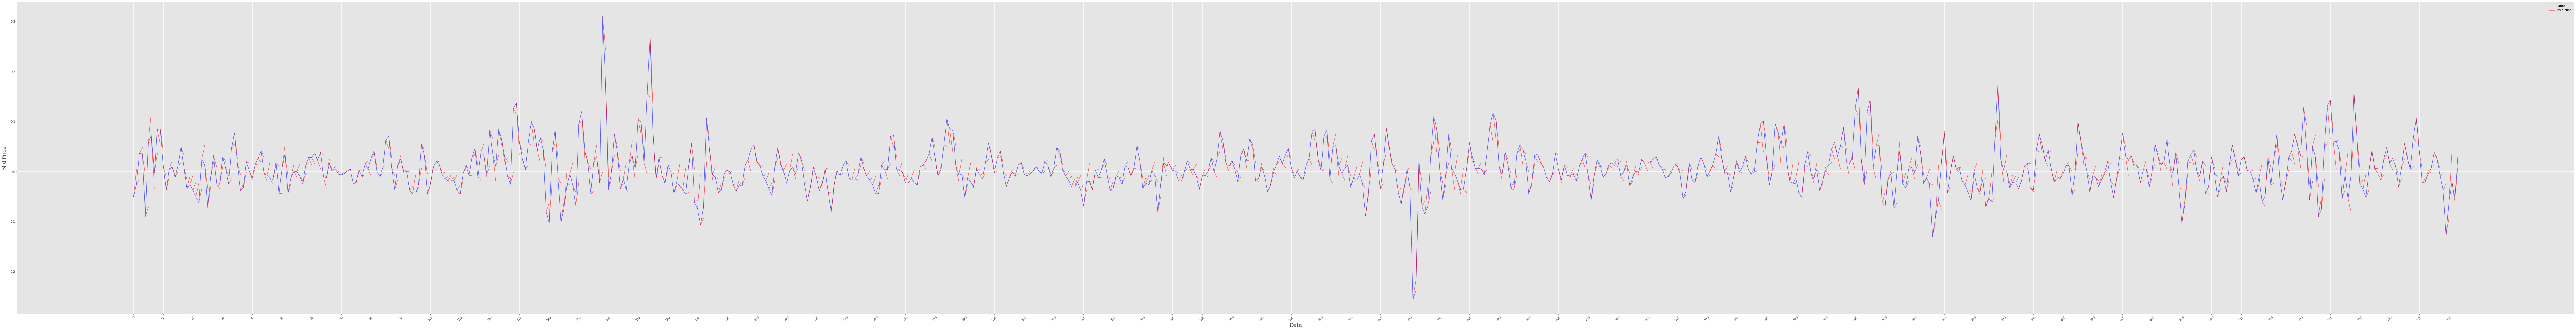

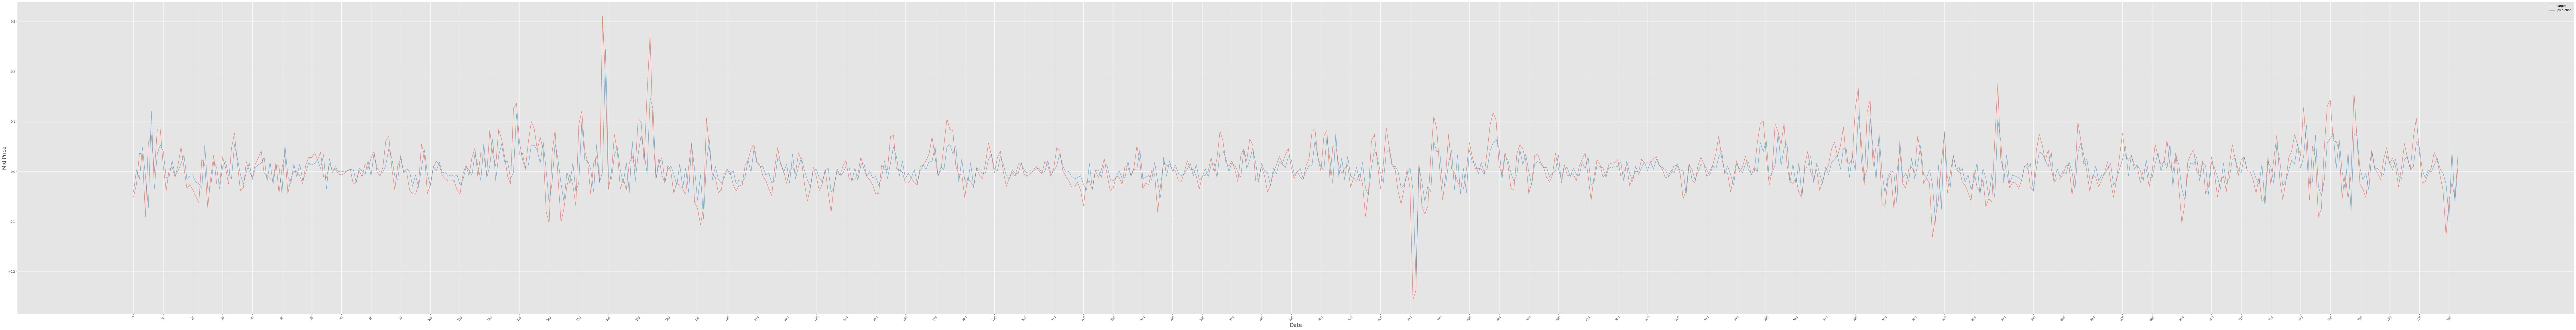

Esse é o score do ChainLink num modelo treinado por cardano


In [15]:
features = [variation]
target = variation
train_X, train_y = to_keras_format(features, target)

features = [alternative_coin_variation]
target = alternative_coin_variation
test_X, test_y = to_keras_format(features, target)

train_and_test(train_data=(train_X, train_y), test_data=(test_X, test_y), epochs=600)
print(f'Esse é o score do {alternative_coin_fullname_str} num modelo treinado por {base_coin_fullname_str}')

desvio padrao

correlação

In [14]:
import pandas as pd
import numpy as np
def variation_to_price(base_price, prices, predictions):
    predicted_prices = np.zeros_like(predictions)
    print(f'predicted_prices: {predicted_prices}')
    # n_samples = len(prices) - N - (foward_days-1)
    last_price = base_price
    for i in range(len(prices)):
        print(f'last_price: {last_price}')
        predicted_prices[i] = last_price + (last_price * predictions[i])
        print(f'predicted_prices: {predicted_prices}')
        last_price = prices[i]
    return predicted_prices

l1 = [1.0,1.5,1.0,0.5,2.0,0.01]
l1 = pd.DataFrame(l1).iloc[:,0]
l2 = l1.pct_change().fillna(0).to_numpy()
l1 = l1.to_numpy()
print(l1)
print(l2)

print('\n')
r = variation_to_price(l1[0], l1[1:], l2[1:])
print(r)

[1.   1.5  1.   0.5  2.   0.01]
[ 0.          0.5        -0.33333333 -0.5         3.         -0.995     ]


predicted_prices: [0. 0. 0. 0. 0.]
last_price: 1.0
predicted_prices: [1.5 0.  0.  0.  0. ]
last_price: 1.5
predicted_prices: [1.5 1.  0.  0.  0. ]
last_price: 1.0
predicted_prices: [1.5 1.  0.5 0.  0. ]
last_price: 0.5
predicted_prices: [1.5 1.  0.5 2.  0. ]
last_price: 2.0
predicted_prices: [1.5  1.   0.5  2.   0.01]
[1.5  1.   0.5  2.   0.01]
